In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt

import urllib
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.feature_selection import RFE

from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb

from gensim.models import Word2Vec
import re

import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
import nltk
from string import punctuation

In [12]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

#Remove unneccasary columns
train.drop(['id', 'host_id'], axis = 1, inplace = True)
test_id = test['id'].copy()
test.drop(['id', 'host_id'], axis = 1, inplace = True)

print('Shape of training data:',train.shape)
print('Shape of testing data:',test.shape)

Shape of training data: (34226, 14)
Shape of testing data: (14669, 13)


12    or  0.0004 % Missing values in  name
13    or  0.0004 % Missing values in  host_name
6982  or  0.204  % Missing values in  last_review
6982  or  0.204  % Missing values in  reviews_per_month


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 <a list of 14 Text xticklabel objects>)

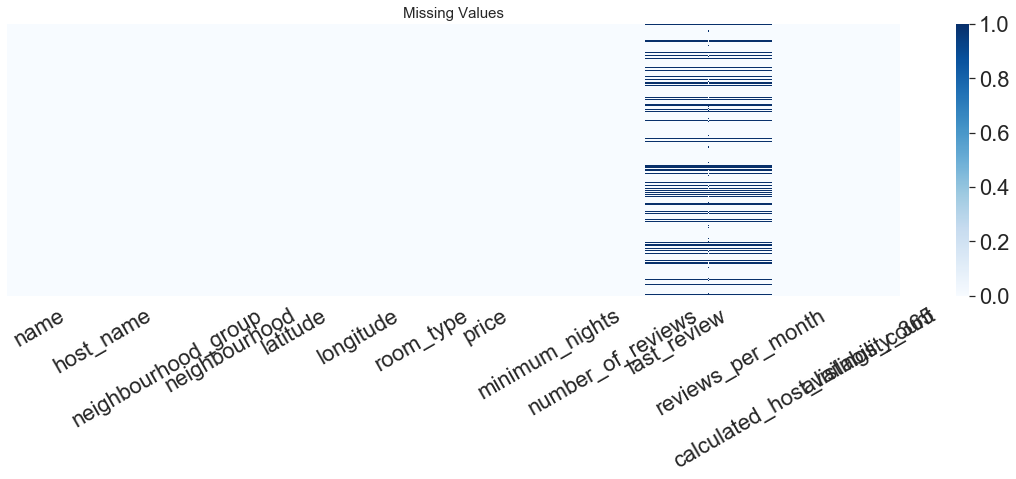

In [13]:
# Check for missing values
count = 0
for i in train.columns:
    if train.isnull().sum()[i] > 0:
        if train.isnull().sum()[i] < 1000:
            print(train.isnull().sum()[count],'   or ',round((train.isnull().sum()[i])/(train.shape[0]),4),'%','Missing values in ',train.columns[count])
        else:
            print(train.isnull().sum()[count],' or ',round((train.isnull().sum()[i])/(train.shape[0]),4),' %','Missing values in ',train.columns[count])
        
    count += 1
        
fig, ax = plt.subplots(figsize=(20,5))
sns.set(font_scale=2)
plt.title('Missing Values', fontsize=15)
sns.heatmap(train.isnull(), cmap="Blues", yticklabels=False, ax=ax)
plt.xticks(rotation = 30)

In [14]:
# Fill missing values
train.name.fillna('no name', inplace = True) # as listing name cannot be imputed
train.host_name.fillna(0, inplace = True) # as host name cannot be imputed
train.last_review.fillna(0, inplace = True) # no date can be specified as no reviews were given.
train.reviews_per_month.fillna(0, inplace = True) # as total number of reviews = 0.


test.name.fillna('no name', inplace = True) # as listing name cannot be imputed
test.host_name.fillna(0, inplace = True) # as host name cannot be imputed
test.last_review.fillna(0, inplace = True) # no date can be specified as no reviews were given.
test.reviews_per_month.fillna(0, inplace = True) # as total number of reviews = 0.

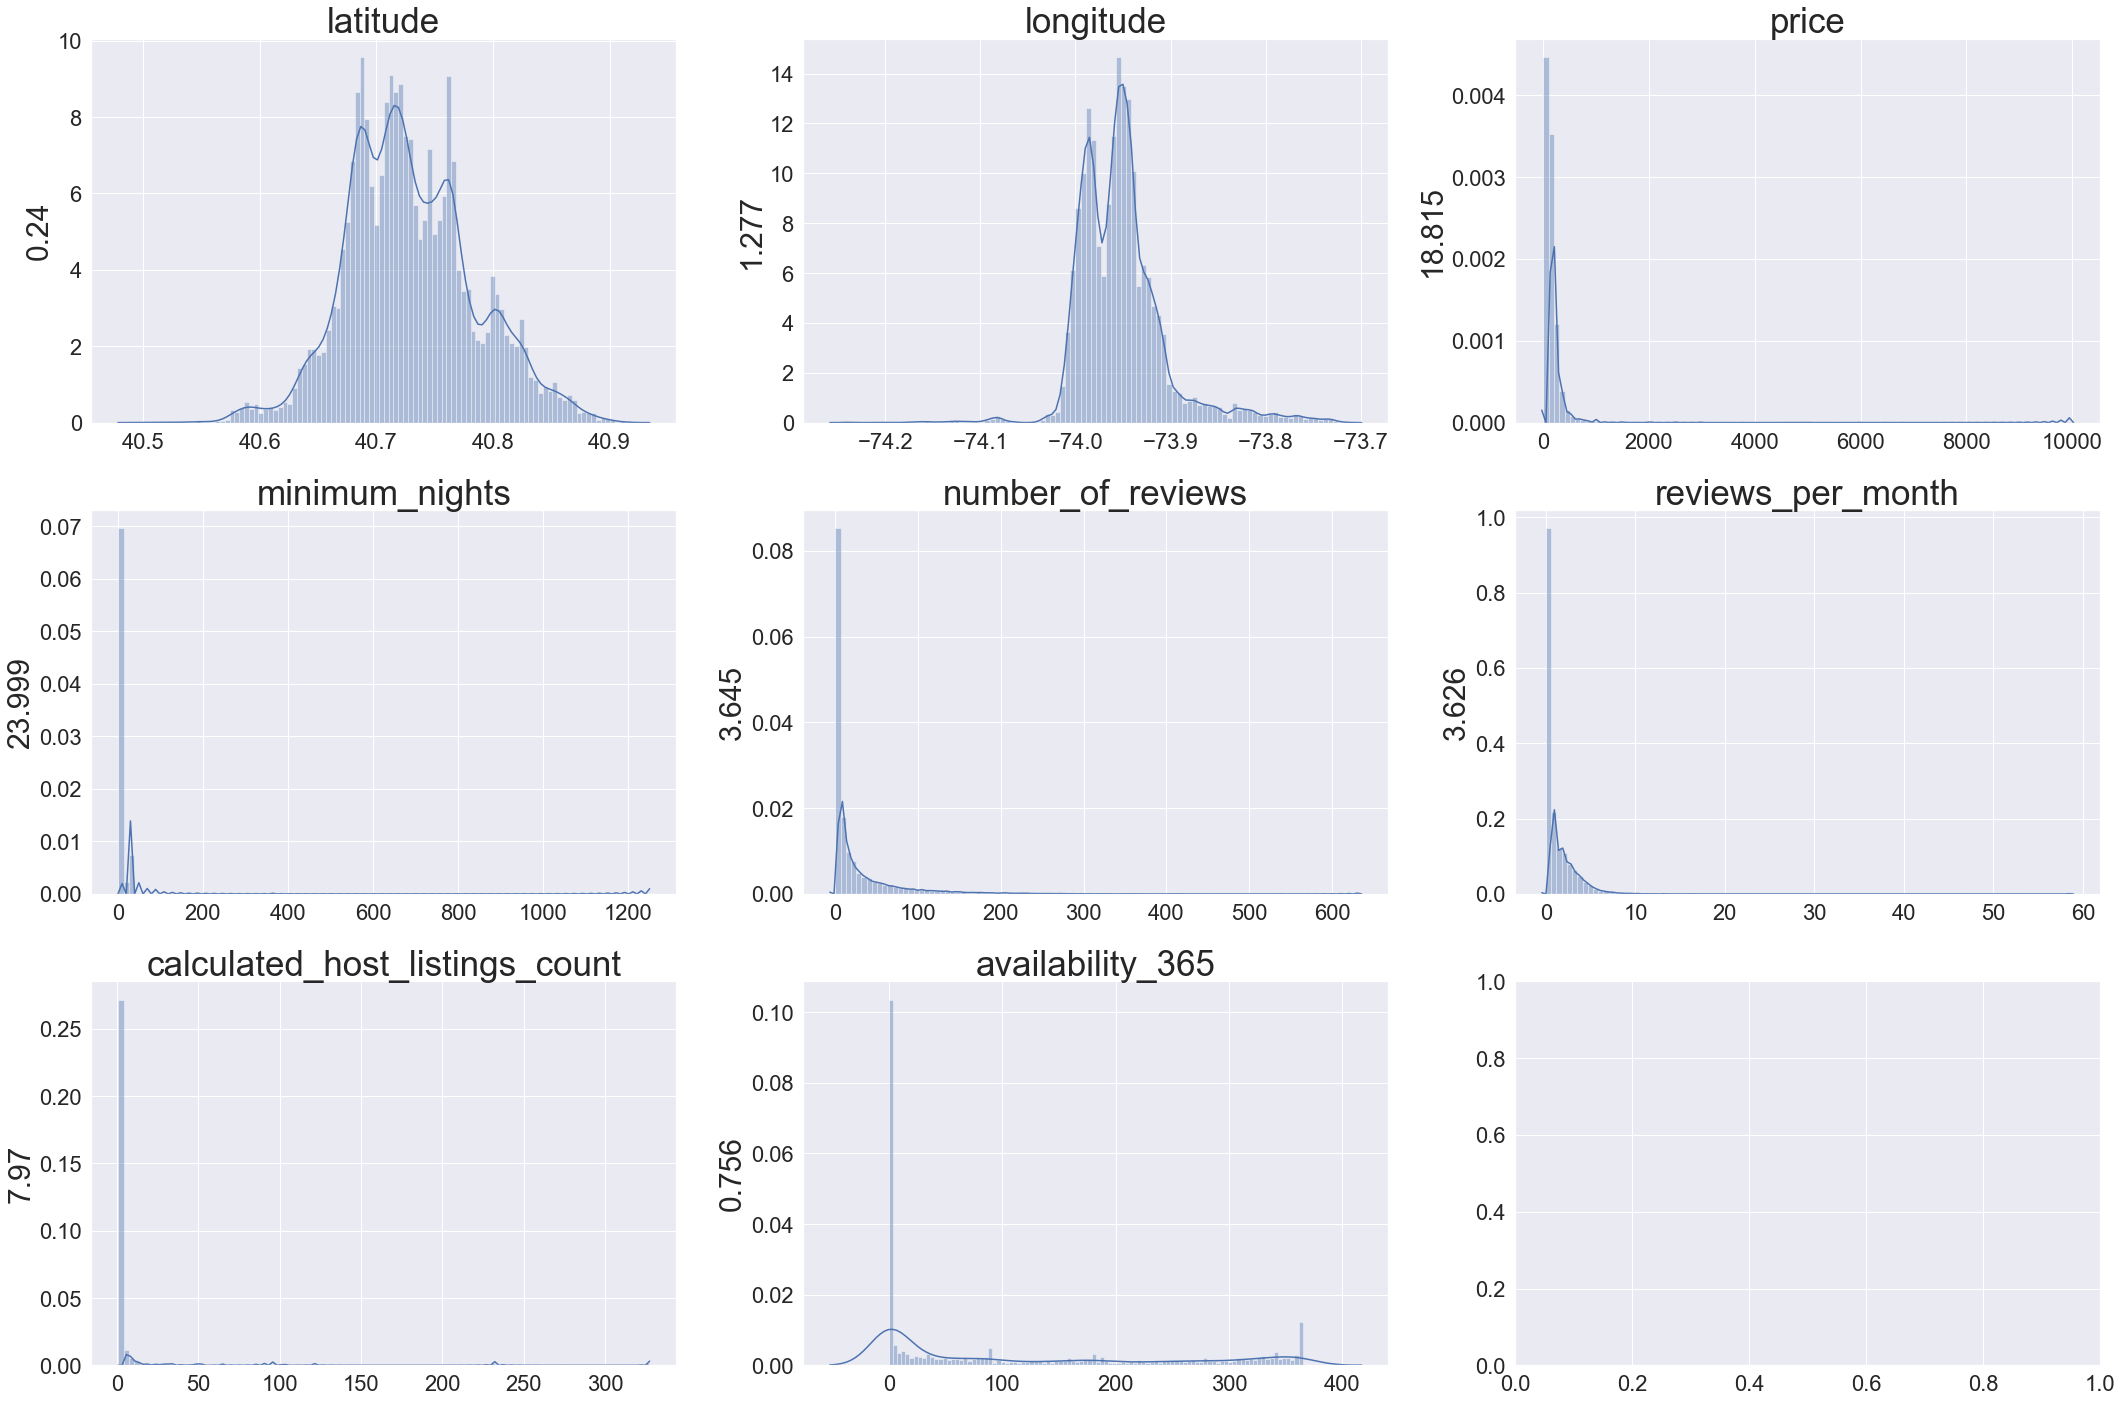

In [15]:
# check for skewness
def skew_plot(df_skew):
    fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (30,20))

    check_for_skewness = df_skew.select_dtypes(include = ['int64', 'float64']).columns
    skew_counter = 0
    for i in range(3):
        for j in range(3): 
            if skew_counter == 8:
                break
            sns.distplot(df_skew[check_for_skewness[skew_counter]], bins = 100, ax = axes[i,j], axlabel='',
                         color="b", label='hoho')
            axes[i,j].set_ylabel(round(df_skew[check_for_skewness[skew_counter]].skew(),3), fontsize = 30)
            axes[i,j].set_title(check_for_skewness[skew_counter], fontsize = 35)
            skew_counter += 1
    plt.tight_layout()
    plt.show()


skew_plot(train)

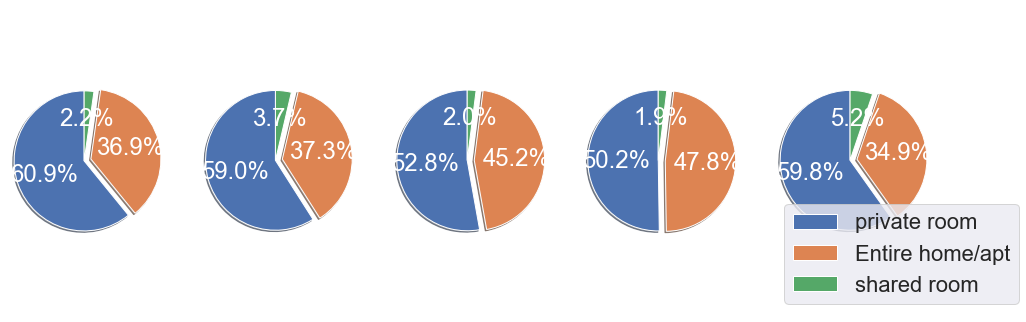

In [16]:
# Neighbourhood group by room_tyep, plotted for ppt
fig, axes = plt.subplots(1,5,figsize = (15,5))
count = 0 #counter for subplot axis
for i in train.neighbourhood_group.unique():
    labels = train[train['neighbourhood_group'] == i].room_type.value_counts(normalize = True).index.to_list()
    sizes = train[train['neighbourhood_group'] == i].room_type.value_counts(normalize = True).values
    
    explo = (0, 0.1, 0)  
    
    axes[count].pie(sizes, explode = explo, shadow=True, autopct='%1.1f%%', textprops={'color':"w"}, startangle=90)
    axes[count].axis('equal')  
    count += 1

plt.legend(['private room','Entire home/apt','shared room'])
plt.tight_layout()
plt.show()

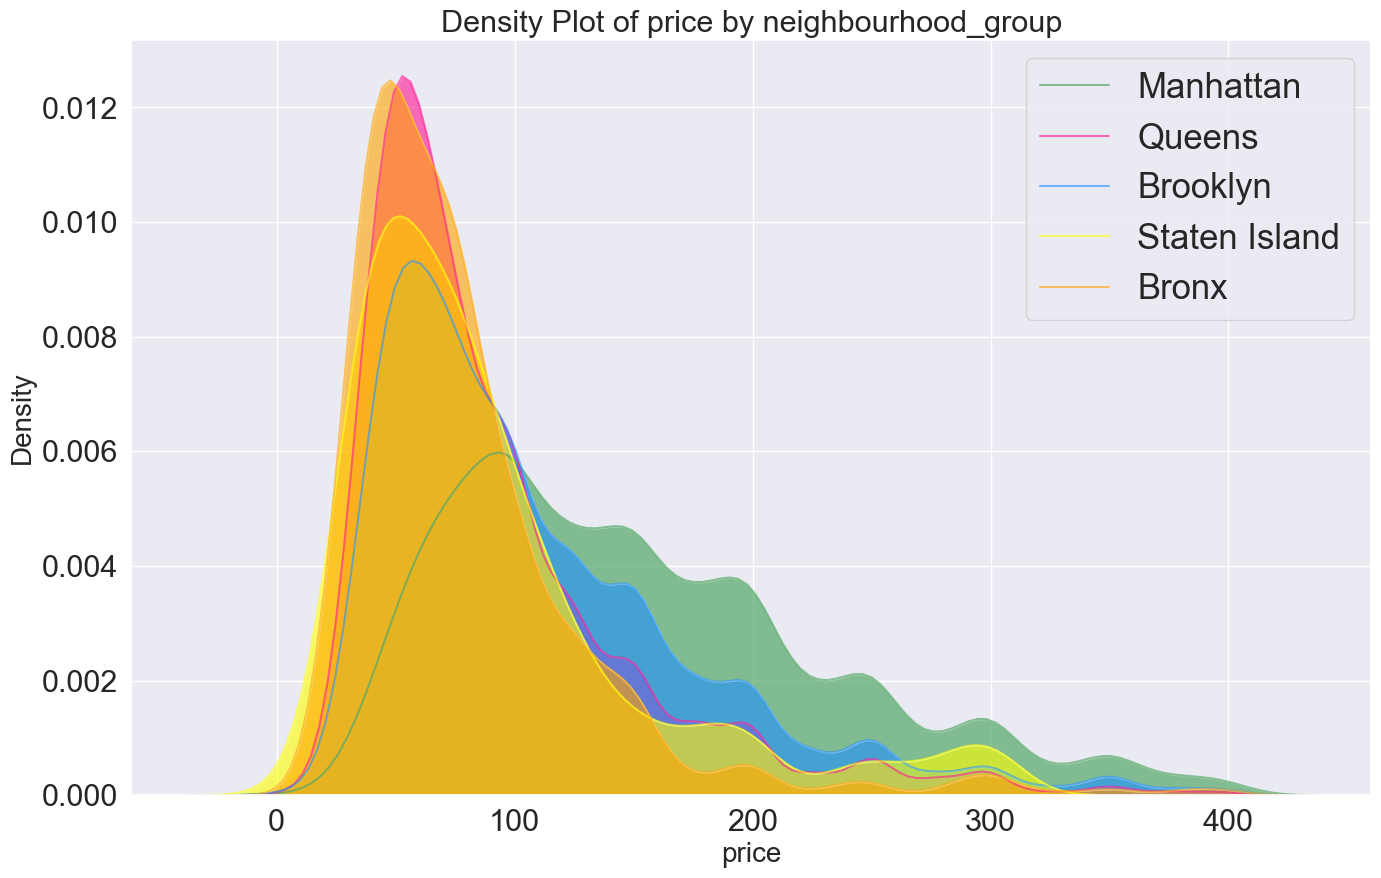

In [17]:
# Draw Plot
density_df = train[train['price'] < 400]
plt.figure(figsize=(16,10), dpi= 100)
sns.kdeplot(density_df.loc[density_df['neighbourhood_group'] == 'Manhattan', "price"], shade=True, color="g", label="Manhattan", alpha=.7)
sns.kdeplot(density_df.loc[density_df['neighbourhood_group'] == 'Queens', "price"], shade=True, color="deeppink", label="Queens", alpha=.6)
sns.kdeplot(density_df.loc[density_df['neighbourhood_group'] == 'Brooklyn', "price"], shade=True, color="dodgerblue", label="Brooklyn", alpha=.6)
sns.kdeplot(density_df.loc[density_df['neighbourhood_group'] == 'Staten Island', "price"], shade=True, color="yellow", label="Staten Island", alpha=.6)
sns.kdeplot(density_df.loc[density_df['neighbourhood_group'] == 'Bronx', "price"], shade=True, color="orange", label="Bronx", alpha=.6)

plt.title('Density Plot of price by neighbourhood_group', fontsize=22)
plt.legend(fontsize = 25)
plt.xlabel('price', fontsize = 20)
plt.ylabel('Density', fontsize = 20)
plt.yticks()
plt.show()

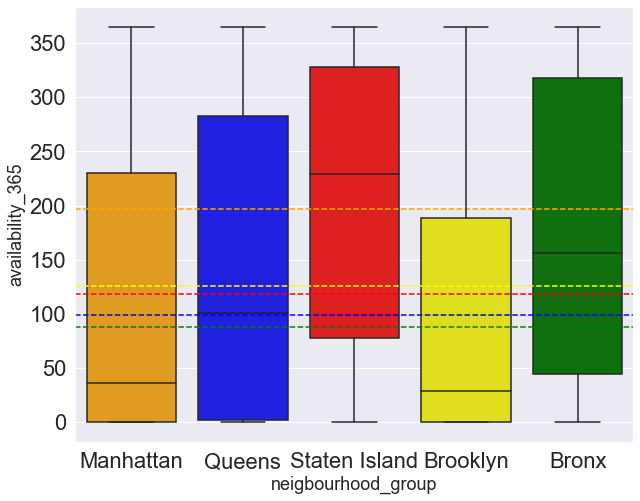

In [18]:
# availability_365 vs price
plt.figure(figsize=(10,8))
ax = sns.boxplot(data=train, x='neighbourhood_group',y='availability_365',palette=['orange','blue','red','yellow','green'])
plt.xlabel('neigbourhood_group', fontsize = 18)
plt.ylabel('availability_365', fontsize = 18)
#plt.axhline(y = [180,220], c='g', marker = '*', label='mean x')

reference = train.groupby('neighbourhood_group')['price'].mean().to_list()
left, right = plt.xlim()
plt.hlines(reference, xmin=left, xmax=right, color=['green','yellow','orange','blue','red'], linestyles='--')

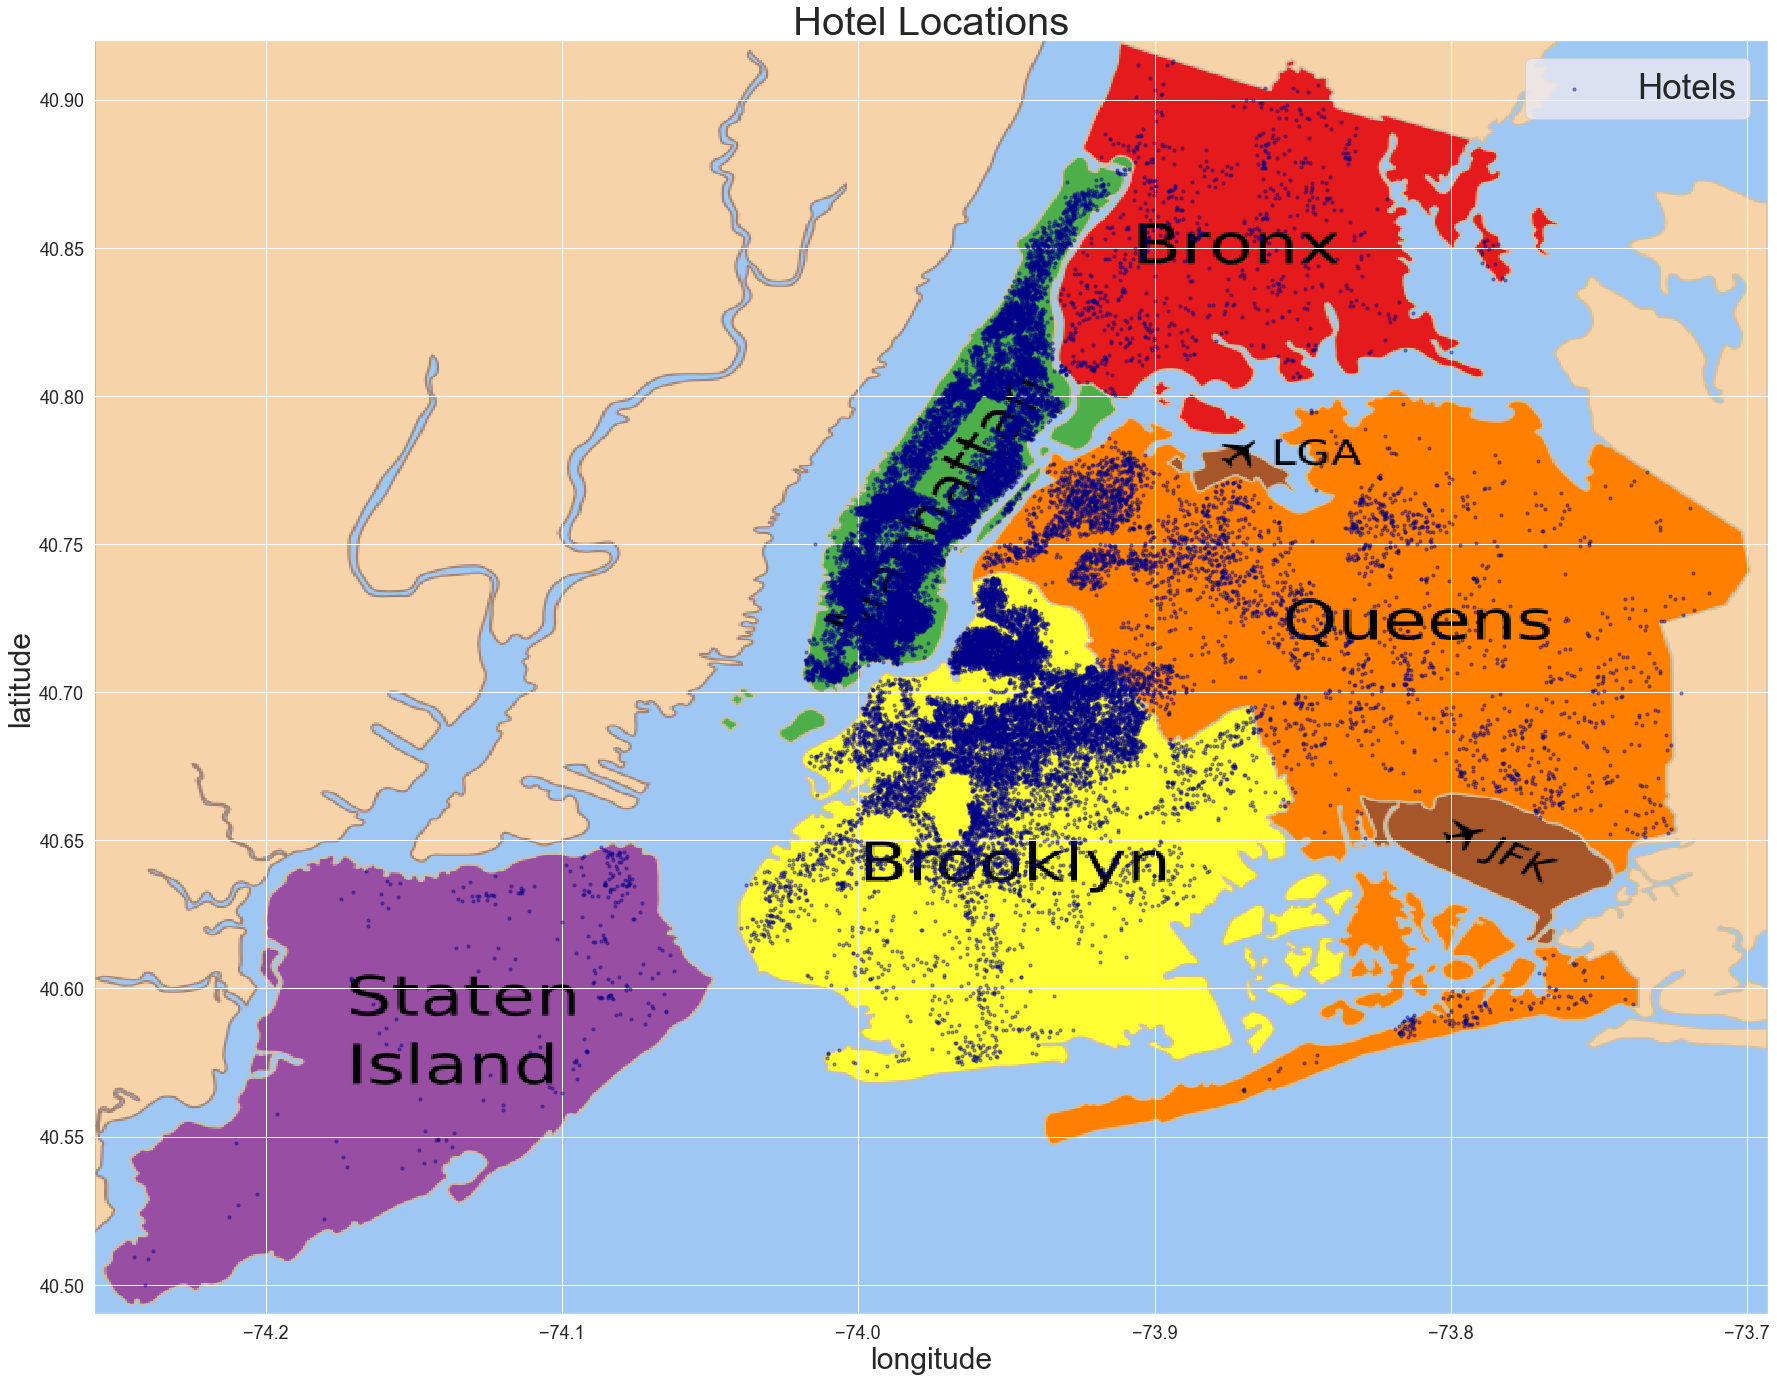

In [19]:
# Hotel Locations
plt.figure(figsize=(30,24))
#Load image from web
i=urllib.request.urlopen('https://i.imgur.com/CkoLYNg.png')
nyc=plt.imread(i)

# scale the image based on the Coordinated (max and mins)
plt.imshow(nyc,zorder=0,extent=[-74.258, -73.693, 40.49,40.92])
ax=plt.gca()

# scatterplot
train.plot(kind='scatter',x='longitude',y='latitude',label='Hotels',s=10,c='darkblue',ax=ax,alpha=0.4,zorder=4, colorbar= False)

plt.legend(fontsize = 35)
plt.title('Hotel Locations', fontsize = (40))
plt.ylabel('latitude', fontsize = 30)
plt.xlabel('longitude', fontsize = 30)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

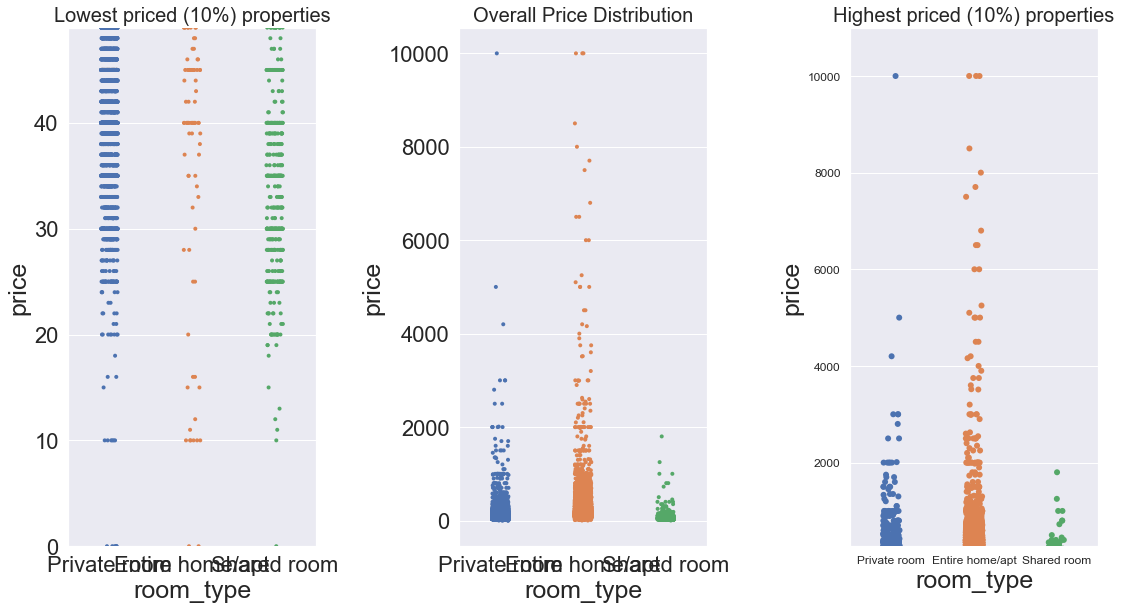

In [20]:
# Price distribution by room_type 
fig, axes = plt.subplots(1,3, figsize = (16,9))
sns.stripplot(x = 'room_type', y = 'price', data = train, size = 4, ax = axes[0])
axes[0].set_ylabel('price', fontsize = 25)
axes[0].set_ylim(0,train.price.quantile(0.1))
axes[0].set_xlabel('room_type', fontsize = 25)
axes[0].set_title('Lowest priced (10%) properties', fontsize = 20)

sns.stripplot(x = 'room_type', y = 'price', data = train, size = 4, ax = axes[1])
plt.xticks(fontsize = 12)
axes[1].set_ylabel('price', fontsize = 25)
axes[1].set_xlabel('room_type', fontsize = 25)
axes[1].set_title('Overall Price Distribution', fontsize = 20)

sns.stripplot(x = 'room_type', y = 'price', data = train, size = 6, ax = axes[2])
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.ylabel('price', fontsize = 25)
plt.ylim(train.price.quantile(0.9),11000)
plt.xlabel('room_type', fontsize = 25)
axes[2].set_title('Highest priced (10%) properties', fontsize = 20)

plt.tight_layout()
plt.show()

In [21]:
print('Count of types of Lowest 10% of property type by price')
low = train[train.price < train.price.quantile(0.1)]['room_type'].value_counts()
print(low)
print('\n')
print('Count of types of Top 10% of property type by price')
high = train[train.price > train.price.quantile(0.9)]['room_type'].value_counts()
print(high)

Count of types of Lowest 10% of property type by price
Private room       2763
Shared room         414
Entire home/apt      73
Name: room_type, dtype: int64


Count of types of Top 10% of property type by price
Entire home/apt    3056
Private room        325
Shared room          22
Name: room_type, dtype: int64


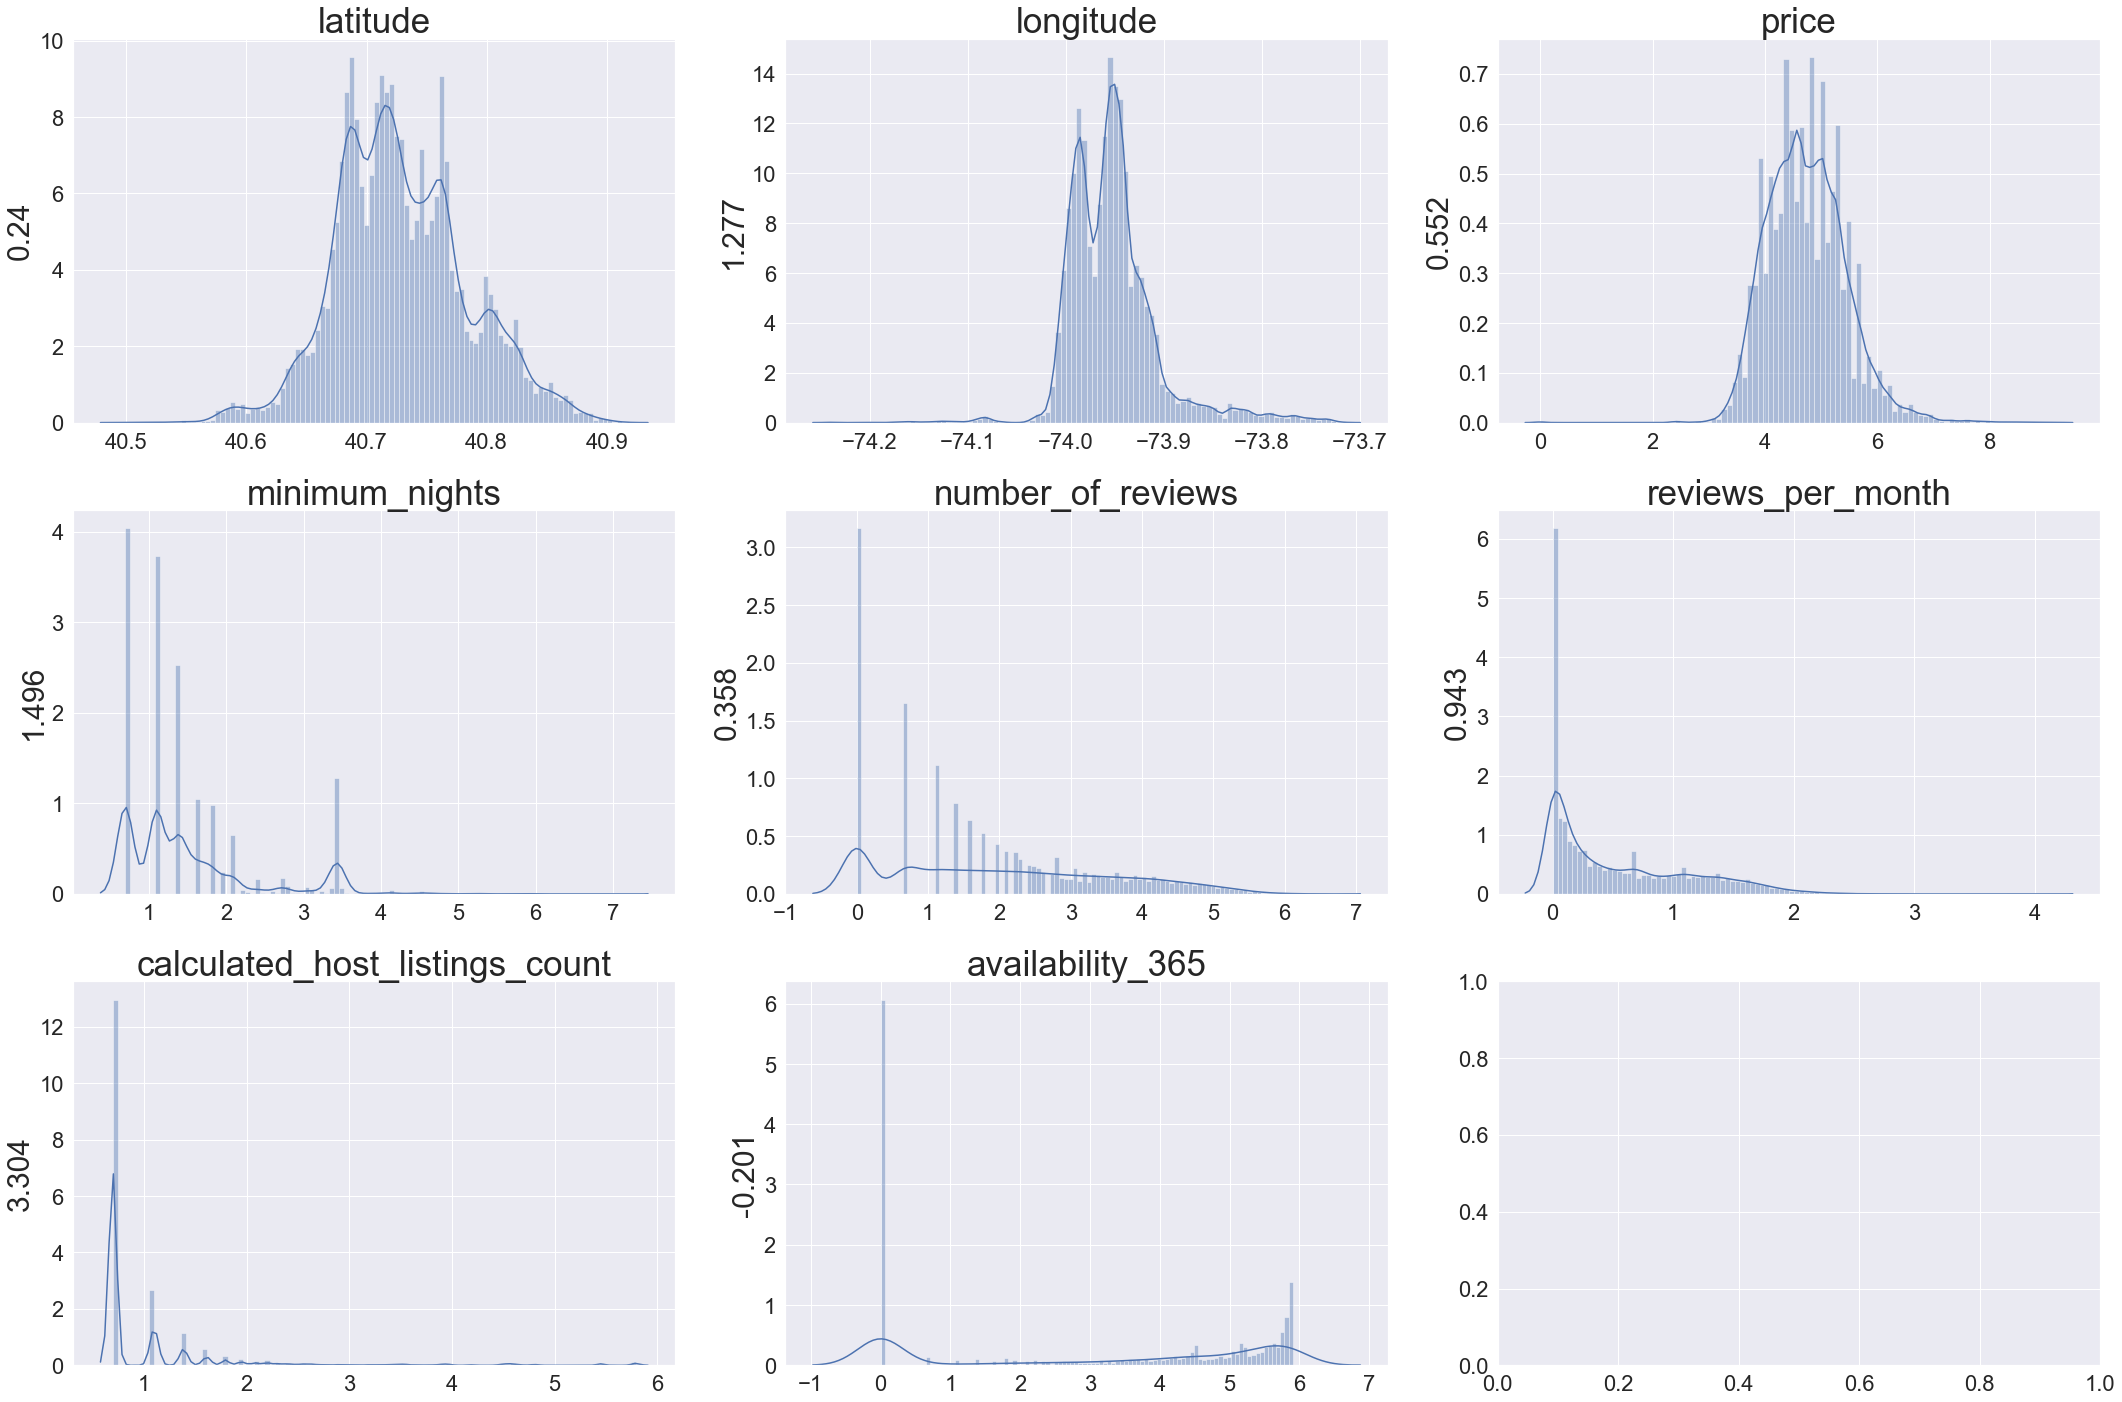

In [22]:
# Treat skewness
skew_treat = train.skew().index[2:]
for i in skew_treat:
    if train[i].skew() > 0.5:
        train[i] = train[i].apply(lambda x: np.log(x + 1))

skew_treat = test.skew().index[2:]
for i in skew_treat:
    if test[i].skew() > 0.5:
        test[i] = test[i].apply(lambda x: np.log(x + 1))
        
skew_plot(train)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text xticklabel objects>)

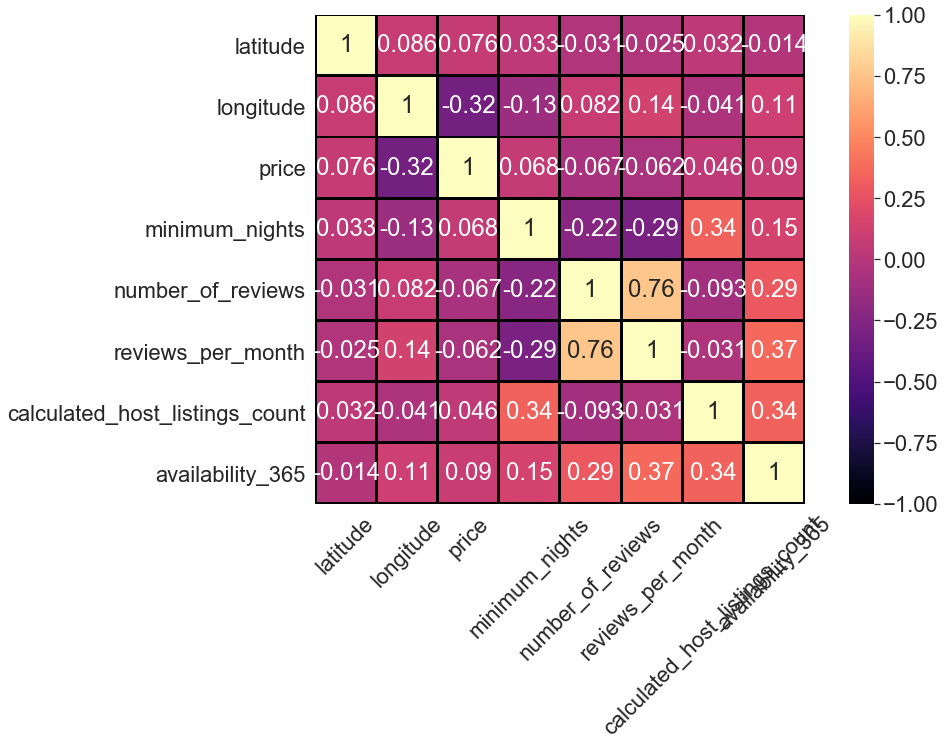

In [23]:
# Check Multicollinarity
plt.figure(figsize = (16,9))
sns.heatmap(train.corr(),annot = True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'magma', linewidths=2, linecolor='black', square=True)
plt.xticks(rotation = 45)

In [24]:
#Outlier Treatment
catgs = train.room_type.unique() #['Private room', 'Entire home/apt', 'Shared room']
for i in catgs:
    # Winsorization, limit outlier at certain percentile value, no upper limit, lower limit = 10%, based on room_type
    upper,lower = train[train.room_type == i].price.quantile(1), train[train.room_type == i].price.quantile(0.1)
    
    for j in range(train.shape[0]):
        if train.iloc[j, -8] == i:
            if train.iloc[j,-7] > upper:
                train.iloc[j,-7] = upper
            elif train.iloc[j,-7] < lower:
                train.iloc[j,-7] = lower
            else:
                pass
        else:
            pass

In [25]:
#check for recency
comb = train.append(test, ignore_index=True)
comb.last_review = pd.to_datetime(comb.last_review)
comb2 = comb.copy()
latest_date = comb2.last_review.max()

comb2.last_review = comb2.last_review.apply(lambda x : (latest_date-x).days)
comb2.last_review = comb2.last_review.apply(lambda x : 3025 if x == 18085 else x) # for zero in date time, day since = 18085
comb2.last_review = comb2.last_review.apply(lambda x : x+1)

comb.last_review =comb2.last_review
train = comb.iloc[:34226,:]
test = comb.iloc[34226:,:]

In [26]:
#combine train & test before encoding as there are a few values that are not present in either train or test data.
# One hot encoding
#comb = train.append(test, ignore_index=True) # already combined while finding recency
x_t = pd.get_dummies(comb.neighbourhood, prefix='neighbourhood', prefix_sep='_')
comb = comb.join(x_t)
comb.drop([comb.columns[-1], 'neighbourhood'], axis = 1, inplace = True)

train = comb.iloc[:34226,:]
test = comb.iloc[34226:,:]

#neighbourhood_group
x_t = pd.get_dummies(train.neighbourhood_group, prefix='n_g', prefix_sep='_')
train = train.join(x_t)
train.drop([train.columns[-1], 'neighbourhood_group'], axis = 1, inplace = True)

x_t = pd.get_dummies(test.neighbourhood_group, prefix='n_g', prefix_sep='_')
test = test.join(x_t)
test.drop([test.columns[-1], 'neighbourhood_group'], axis = 1, inplace = True)

#room_type
x_t = pd.get_dummies(train.room_type)
train = train.join(x_t)
train.drop([train.columns[-1], 'room_type'], axis = 1, inplace = True)

x_t = pd.get_dummies(test.room_type)
test = test.join(x_t)
test.drop([test.columns[-1], 'room_type'], axis = 1, inplace = True)

In [27]:
# drop host_name & NaN price column created in Test due to combing it with Train.
train.drop(['host_name'], axis = 1, inplace = True)
test.drop(['host_name','price'], axis = 1, inplace = True)

In [28]:
custom_set_of_stopwords = set(stopwords.words('english')+list(punctuation))
df = train.append(test, ignore_index = True)
clean_txt = []
for w in range(len(df.name)):
    desc = df['name'][w].lower()
    
    #remove punctuation
    desc = re.sub('[^a-zA-Z]', ' ', desc)
    
    #remove tags
    desc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",desc)

    #remove special chars, digits
    desc=re.sub("(\\d|\\W)+"," ",desc)
    clean_txt.append(desc)
df['cleaned_name'] = clean_txt
df.head()

corpus = []
for col in df.cleaned_name:
    word_list = col.split(" ")
    corpus.append(word_list)

for i in range(len(corpus)):
    corpus[i] = [x for x in corpus[i] if x not in custom_set_of_stopwords]
    
#generate vectors
model = Word2Vec(corpus, min_count=1, size = 30)

embeds = []
for i in range(df.shape[0]):
    divider = 0
    summer = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    tester = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for j in range(len(df.iloc[i,-1].split(' '))):
        w_f = df.iloc[i,-1].split(' ')[j]
        if (len(w_f) > 2) & (w_f not in custom_set_of_stopwords):   # 'and') & (w_f != ('with')) & (w_f != ('haven')):
            divider +=1
            summer = np.add(model[df.iloc[i,-1].split(' ')[j]],summer)
    all_zero_flag = 0 
    for i in range(len(summer)):
        if summer[i] == 0:
            all_zero_flag += 1
        
    if all_zero_flag == 0:
        embeds.append(summer/divider)
    else:
        embeds.append(summer)
        
t_embeds = embeds.copy()    
df_embeds = pd.DataFrame(t_embeds, columns = ['v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16',
                                    'v17','v18','v19','v20','v21','v22','v23','v24','v25','v26','v27','v28','v29','v30'])

df22 = pd.concat([df,df_embeds], axis = 1)
df22.drop(['name','cleaned_name'],axis=1,inplace = True)
train = df22.iloc[:34226,:]
test = df22.iloc[34226:,:]
test.drop(['price'], axis = 1, inplace = True)

In [29]:
# Drop reviews_per_month due to collinearity and also last_review
train.drop(['reviews_per_month','last_review'],axis = 1, inplace = True)
test.drop(['reviews_per_month','last_review'],axis = 1, inplace = True)

X = train.drop('price', axis =1)
y = train['price'].copy()

# Feature Scaling
ss = StandardScaler()
X = ss.fit_transform(X)
test = ss.transform(test)

In [31]:
# k-fold cross validation
ri_cv = Ridge(max_iter = 1500)
rf_cv = RandomForestRegressor(n_jobs = 4)
xgb_cv = XGBRegressor()

print('RMSE Errors for log1p(price)')
cv_en = cross_val_score(ri_cv, X, y, cv = 10, scoring = 'neg_root_mean_squared_error').mean()
print('For ElasticNet :', -1 *cv_en)
cv_rf = cross_val_score(rf_cv, X, y, cv = 10, scoring = 'neg_root_mean_squared_error').mean()
print('For RandomForestRegressor :', -1 *cv_rf)
cv_xgb = cross_val_score(xgb_cv, X, y, cv = 10, scoring = 'neg_root_mean_squared_error').mean()
print('For XGBoost :', -1 *cv_xgb)

RMSE Errors for log1p(price)
For ElasticNet : 0.4259933130764922
For RandomForestRegressor : 0.4102059512423114
For XGBoost : 0.4111941679726875


In [32]:
# split Data
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.2,random_state = 14) 

In [ ]:
rf=RandomForestRegressor()
rfe = RFE(estimator = rf, step = 1, verbose =0)
rfe.fit(xtrain,ytrain)

selected_fs = pd.DataFrame({'features': list(xtrain.columns),
                           'ranks': rfe.ranking_})
selected_fs.sort_values(by = 'ranks').iloc[0:30,:]

xtrain_rfe = rfe.transform(xtrain)
xtest_rfe = rfe.transform(xtest)
test_rfe = rfe.transform(test)

In [63]:
#Ridge
en = Ridge()
ypred_en = en.fit(xtrain,ytrain).predict(xtest)

y_true_scale = []
pred_true_scale = []
for i in range(6846):
    y_true_scale.append((np.expm1(ytest.iloc[i])))
    pred_true_scale.append((np.expm1(ypred_en[i])))
    
en_rmse = np.sqrt(mean_squared_error(y_true_scale, pred_true_scale))
print('test error: ', round(en_rmse,3))
print('r2_  score: ', round(r2_score(y_true_scale, pred_true_scale),3))

# test data prediction
predic = en.predict(test)
pred1_1 = []
for i in range(len(predic)):
    pred1_1.append((np.exp(predic[i]))-1)

sub = pd.DataFrame({'id':test_id,'price':pred1_1})
#sub.to_csv('final_ridge.csv', index = False)

test error:  169.064
r2_  score:  0.198


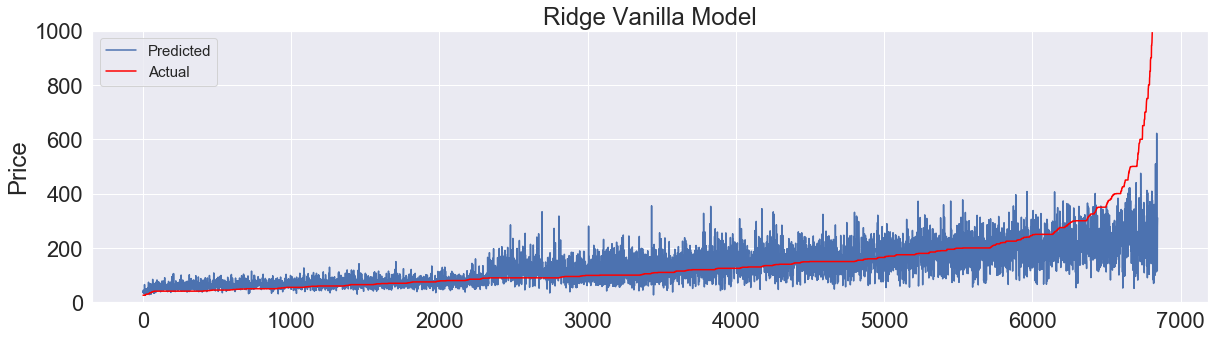

In [37]:
g_en = pd.DataFrame({'actual' : y_true_scale,'predicted': pred_true_scale})
g_en = g_en.sort_values(by="actual").reset_index()
plt.figure(figsize = (20,5))
plt.plot(g_en['predicted'])
plt.plot(g_en['actual'], color = 'red')
plt.ylim(0,1000)
plt.legend(['Predicted','Actual'],fontsize = 15)
plt.title('Ridge Vanilla Model')
plt.ylabel('Price')
plt.show()

In [64]:
# RandomForestRegressor
rf=RandomForestRegressor(n_jobs = 4)
ypred_rf = rf.fit(xtrain,ytrain).predict(xtest)

y_true_scale = []
pred_true_scale = []
for i in range(6846):
    y_true_scale.append((np.expm1(ytest.iloc[i])))
    pred_true_scale.append((np.expm1(ypred_rf[i])))
    
rf_rmse = np.sqrt(mean_squared_error(y_true_scale, pred_true_scale))
print('true scale test error: ', round(rf_rmse,3))
print('true scale r2_score: ', round(r2_score(y_true_scale, pred_true_scale),3))

# test data prediction
predic = rf.predict(test)
pred1_1 = []
for i in range(len(predic)):
    pred1_1.append((np.exp(predic[i]))-1)
    
sub = pd.DataFrame({'id':test_id,'price':pred1_1})
#sub.to_csv('final_rfv.csv', index = False)

true scale test error:  167.008
true scale r2_score:  0.217


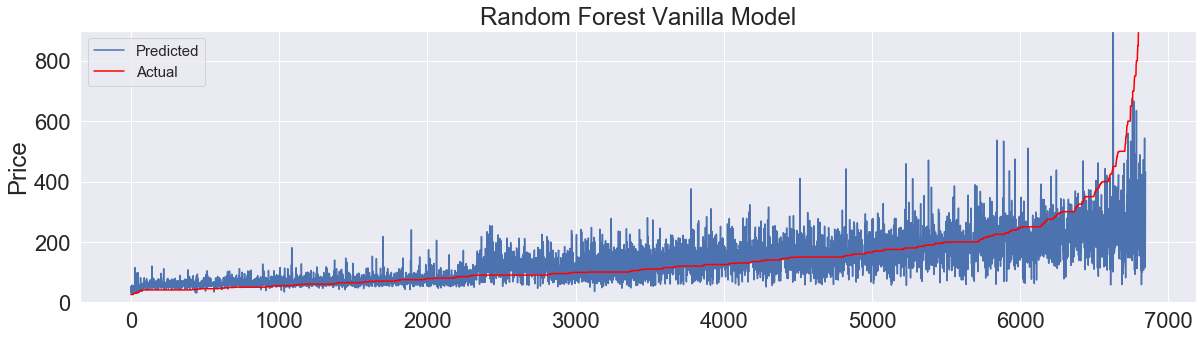

In [39]:
g_rf = pd.DataFrame({'actual' : y_true_scale,'predicted': pred_true_scale})
g_rf = g_rf.sort_values(by="actual").reset_index()
plt.figure(figsize = (20,5))
plt.plot(g_rf['predicted'])
plt.plot(g_rf['actual'], color = 'red')
plt.ylim(0,900)
plt.legend(['Predicted','Actual'],fontsize = 15)
plt.title('Random Forest Vanilla Model')
plt.ylabel('Price')
plt.show()

In [65]:
# XGBoost
xgb = XGBRegressor()
ypred_xgb = xgb.fit(xtrain,ytrain).predict(xtest)

y_true_scale = []
pred_true_scale = []
for i in range(6846):
    y_true_scale.append((np.expm1(ytest.iloc[i])))
    pred_true_scale.append((np.expm1(ypred_xgb[i])))
    
xgb_rmse = np.sqrt(mean_squared_error(y_true_scale, pred_true_scale))
print('true scale test error: ', round(xgb_rmse,3))
print('true scale r2_score: ', round(r2_score(y_true_scale, pred_true_scale),3))

# test data prediction
predic = xgb.predict(test)
pred1_1 = []
for i in range(len(predic)):
    pred1_1.append((np.exp(predic[i]))-1)
    
sub = pd.DataFrame({'id':test_id,'price':pred1_1})
#sub.to_csv('final_xgbv.csv', index = False)

true scale test error:  165.342
true scale r2_score:  0.233


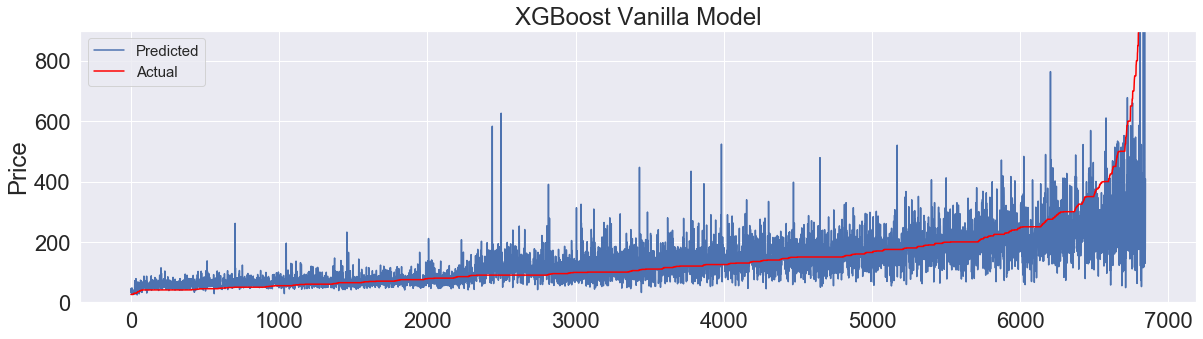

In [41]:
g_xgb = pd.DataFrame({'actual' : y_true_scale,'predicted': pred_true_scale})
g_xgb = g_xgb.sort_values(by="actual").reset_index()
plt.figure(figsize = (20,5))
plt.plot(g_xgb['predicted'])
plt.plot(g_xgb['actual'], color = 'red')
plt.ylim(0,900)
plt.legend(['Predicted','Actual'],fontsize = 15)
plt.title('XGBoost Vanilla Model')
plt.ylabel('Price')
plt.show()

In [61]:
# Hyper parameter tuning needs to be performed every time, after finding wordr2vec vectors, as it changes every time!
# XGBoost Hyperparameter tuning without cross-validation
grid = {'max_depth':[6],
        'gamma':[0],
        'subsample':[0.9],
        'colsample_bytree':[1],
        'reg_alpha':[0],
        'learning_rate' : [0.3],
        'min_child_weight':[1],
        'n_estimators': [160],
}

best_score = 500
for g in ParameterGrid(grid):
    xgb=XGBRegressor()
    xgb.set_params(**g)
    xgb.fit(xtrain,ytrain)
    ypred3_2 = xgb.predict(xtest)

    # for inv log1p
    ytrue = []
    ypred = []
    for i in range(6846):
        ytrue.append((np.expm1(ytest.iloc[i])))
        ypred.append((np.expm1(ypred3_2[i])))

    e = np.sqrt(mean_squared_error(ytrue, ypred))
    
    xgb_rmse = np.sqrt(mean_squared_error(ytrue, ypred))
    print('true scale test error: ', round(xgb_rmse,3))
    print('true scale r2_score: ', round(r2_score(ytrue, ypred),3))
    
    if xgb_rmse < best_score:
        best_score = xgb_rmse
        #print(xgb_rmse)
        #print(g)
    
    #test data prediction
    predic = xgb.predict(test)
    pred1_1 = []
    for i in range(len(predic)):
        pred1_1.append((np.expm1(predic[i])))
        
#sub = pd.DataFrame({'id':test_id,'price':pred1_1})
#sub.to_csv('final1.csv', index = False)

true scale test error:  164.092
true scale r2_score:  0.244


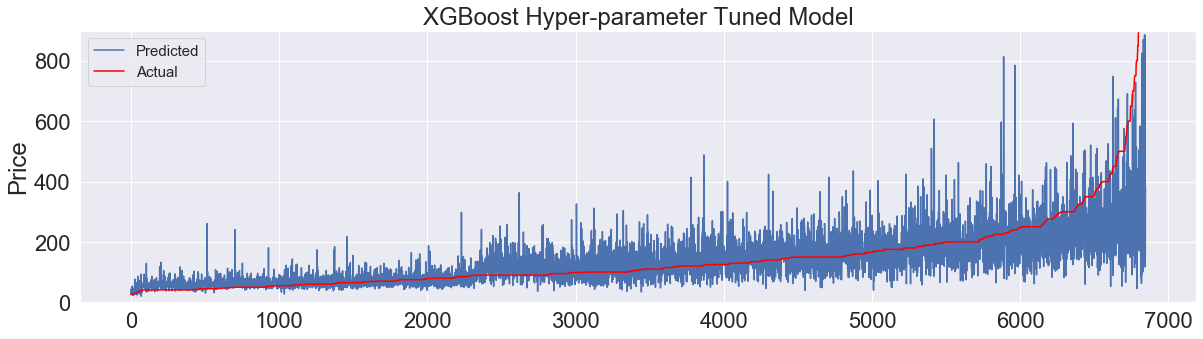

In [60]:
g_xgb = pd.DataFrame({'actual' : ytrue,'predicted': ypred})
g_xgb = g_xgb.sort_values(by="actual").reset_index()
plt.figure(figsize = (20,5))
plt.plot(g_xgb['predicted'])
plt.plot(g_xgb['actual'], color = 'red')
plt.ylim(0,900)
plt.legend(['Predicted','Actual'],fontsize = 15)
plt.title('XGBoost Hyper-parameter Tuned Model')
plt.ylabel('Price')
plt.show()